In [16]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling
from pathlib import Path

### Step 1: Load Clean Dataset

In [3]:
data_path = Path("churn_clean.csv")
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Shape: (10000, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Data Preprocessing

In [4]:
# Separate features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [5]:
# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [6]:
# Column transformer
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

X_prepared = ct.fit_transform(X)

### Step 3: Split the dataset into training and test sets

In [7]:
# 80% of the data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared,   
    y,            
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [8]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("y_train ratio:", y_train.mean().round(3))
print("y_test  ratio:", y_test.mean().round(3))

Training set shape: (8000, 11)
Test set shape: (2000, 11)
y_train ratio: 0.204
y_test  ratio: 0.204


### Step 4：Baseline Model: Logistic Regression

In [9]:
# Build the model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [10]:
# Make predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

In [11]:
print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.777
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000



Interpretation: ROC-AUC=0.777 means this logistic regression model has good ability to different the churn customer and retain customers. The customers who are churned (Class 1), precision is 0.39, it is quite low, some cursomers are predicted churn, but actually they are not leaving. We found 70% customers will leave.

### Step 5: Model Evaluation & Plots

In [12]:
# Create output folder
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

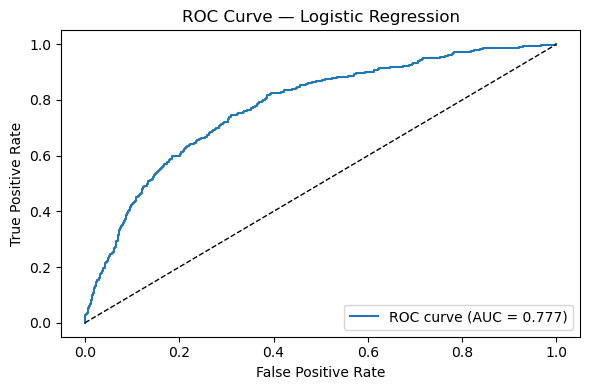

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curve_logreg.png", dpi=200)
plt.show()

In [17]:
# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

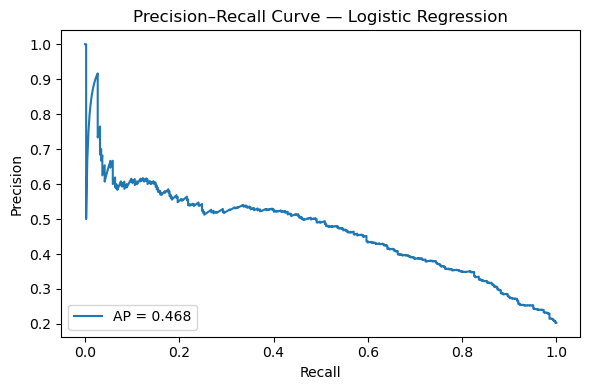

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(FIG_DIR / "pr_curve_logreg.png", dpi=200)
plt.show()

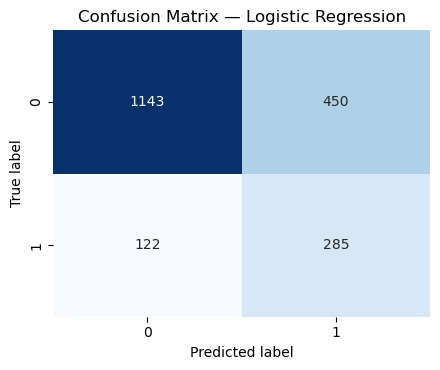

In [ ]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix_logreg.png", dpi=200)
plt.show()